In [56]:
import numpy as np
import matplotlib.pyplot as plt

In [171]:
parties = np.array(['A','B','C','F','I','M','O','V','Æ','Ø','Å'])
num_parties = len(parties)
valgforbund = [
               [[0,10,3],[1,5,7],[2,4],[6],[8],[9]],
               [[i] for i in range(num_parties)]
              ]

SIM = True
poll = ['epinion','altinget','actual'][1] #change index accordingly

N = 10_000 if SIM else 1
M = 15


#Actual results
pollSize = 2_500_000
mu = 1/100*np.array([15.6,7.1,8.8,17.4,7.0,6.0,6.4,14.7,7.4,7.0,2.7])

#Epinion poll 6/6
if poll == 'epinion':
    pollSize = 2085
    mu = 1/100*np.array([17.7,4.9,8.3,16.6,8.5,6.0,6.4,10.8,8.9,7.8,4.1])

#Altinget vægtet 9/6
if poll == 'altinget':
    pollSize = 5000
    mu = 1/100*np.array([18.9,5.2,7.4,15.8,9.9,5.5,7.1,11.6,9.1,6.9,2.6])

sigma = np.diag(np.sqrt(mu*(1-mu)/pollSize)) if SIM else np.diag(np.zeros(len(parties))) 

In [172]:
#Generate votes, assuming independent normal distrubutions
votes         = np.clip(np.random.multivariate_normal(mu,sigma,N),0,1)
norm_votes    = votes/np.expand_dims(np.linalg.norm(votes,1,axis = 1),1)

In [173]:
def valgforbund_votes(valgforbund):

    #Collect total votes for each valgforbund
    vf_coll_votes = np.array([norm_votes[:,f].sum(axis=1) for i, f in enumerate(valgforbund)]).T

    #Percentage of votes for each party in every valgforbund
    vf_ind_votes  = [norm_votes[:,f] for f in valgforbund]
    vf_ind_votes  = [viv/np.expand_dims(np.linalg.norm(viv,1,axis = 1),1) for viv in vf_ind_votes]
    
    return vf_coll_votes,vf_ind_votes

In [174]:
#Vectorized function for mandate count
def dhondt(V,M = M):
    mandates = np.zeros_like(V,dtype = np.int32)
    row_idx = np.arange(V.shape[0])
    for i in range(M):
        winner = np.argmax(V/(mandates+1),axis = 1) #recomputing all, but only N changes
        mandates[row_idx,winner]+=1
    return mandates

#Non-vectorized function for mandate count, because different M values
#Definitly not neccesary
def dhondt_ind(V, M=M):
    mandates = np.zeros_like(V,dtype = np.int32)
    for i in range(M):
        winner = np.argmax(V/(mandates+1)) 
        mandates[winner]+=1
    return mandates

In [175]:
def flatten(xss):
    return [x for xs in xss for x in xs]


def compute_vf_mandates(valgforbund):
    #compute valgforbund votes
    vf_coll_votes,vf_ind_votes = valgforbund_votes(valgforbund)

    #Compute valgforbund mandates
    m_forbund = dhondt(vf_coll_votes)

    #Compute individual party mandates
    finalMan = np.array(
                [flatten([dhondt_ind(vf_ind_votes[j][i],m) 
                for j,m in enumerate(mDist) ]) 
                for i,mDist in enumerate(m_forbund)])
    return finalMan


In [178]:
#Plot simulation statistics
def plot(mandates,valgforbund):
    p = [parties[i] for i in flatten(valgforbund)]
    mean= [np.mean(mandates,axis = 0)[p.index(n)] for n in parties]
    std = [np.std(mandates,axis = 0)[p.index(n)] for n in parties]
    color = ['red','purple','yellowgreen','pink','turquoise','lavender','khaki','grey','cornflowerblue','orange','green']
    if SIM:
        plt.errorbar(parties, mean, std, elinewidth = 5,linestyle='None', marker='.', ecolor = color,color = 'black')
        plt.title(f'Gennensnit +- std over {N} simuleringer\n valgforbund = {[list(parties[f]) for f in valgforbund]}')
    else:
        plt.bar(parties,mean,color = color)
        plt.title(f'Mandatfordeling\n valgforbund = {[list(parties[f]) for f in valgforbund]}')
    plt.xlabel('Parti')
    plt.ylabel('Antal mandater')
    
    plt.show()


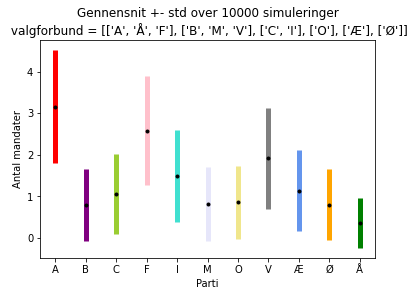

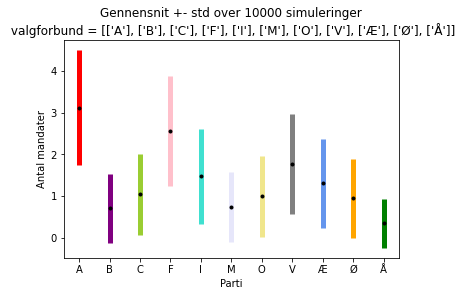

In [180]:
for vf in valgforbund:
    np.seterr(invalid='ignore')
    vf_mand = compute_vf_mandates(vf)
    plot(vf_mand,vf)